# A guide to paticle motion estimation with `pyusel-dispest`

In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

# Define the imaging setup and dispacement field

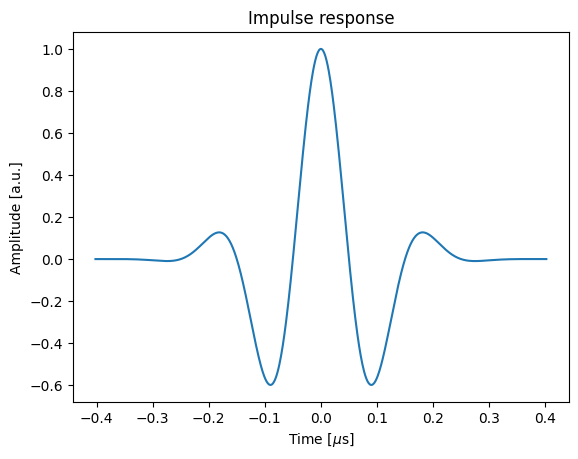

In [2]:
# define the imaging PSF
bw=80/100
f = 5E6
c = 1540
fs = 1E9

tc = sig.gausspulse('cutoff', bw=bw, tpr=-80, fc=f)
Ntc = np.ceil(tc*fs)
timp = (np.arange(2*Ntc+1)-Ntc)/fs
imp = sig.gausspulse(t=timp, bw=bw, tpr=-80, fc=f)

plt.figure()
plt.plot(1E6*timp, imp)
plt.xlabel("Time [$\mu$s]")
plt.ylabel("Amplitude [a.u.]")
plt.title("Impulse response")
plt.show()

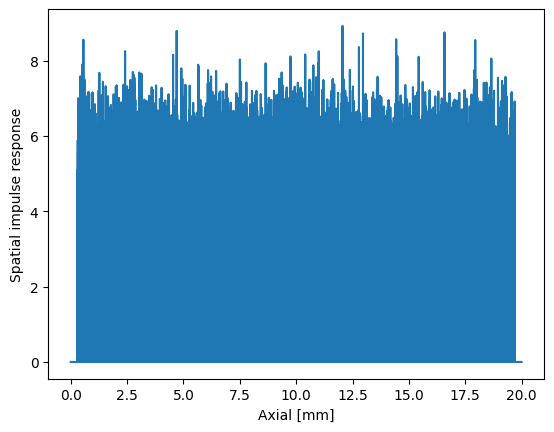

In [3]:
# define the scatterer field
dx = c/(2*fs)
x = np.arange(0, 20E-3, dx)
rng = np.random.default_rng()

x0 = rng.uniform(dx*Ntc, dx*(len(x)-Ntc), 10000)
ix0 = np.round(x0/dx).astype(int)
a0 = rng.normal(5, 1, 10000)
a0[a0 <= 0.1] = 0.1
scat = np.zeros(len(x))
scat[ix0] += a0

plt.figure()
plt.plot(1E3*x, scat)
plt.xlabel("Axial [mm]")
plt.ylabel("Spatial impulse response")
plt.show()

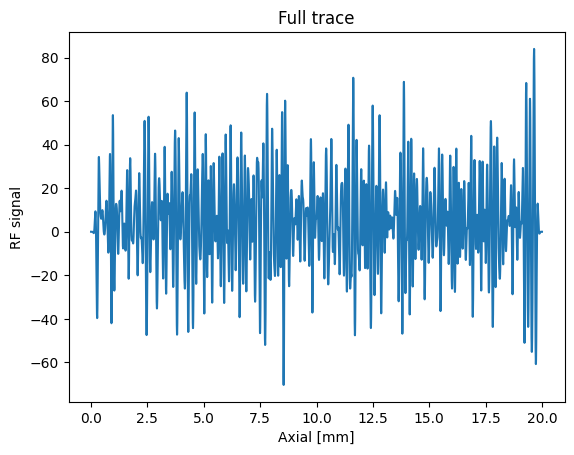

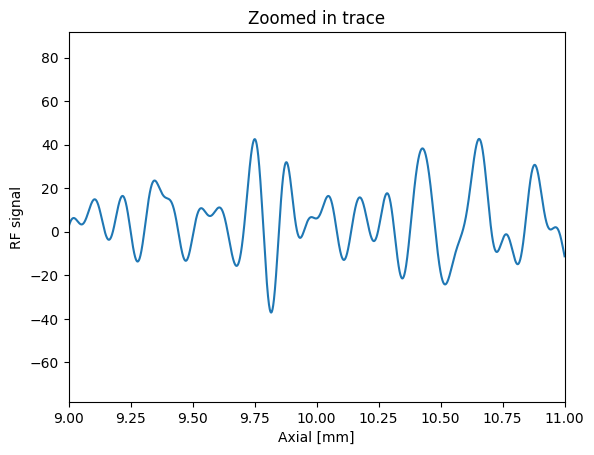

In [4]:
trace0 = np.convolve(imp, scat, mode='same')

plt.figure()
plt.plot(1E3*x, trace0)
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Full trace")
plt.show()

plt.figure()
plt.plot(1E3*x, trace0)
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Zoomed in trace")
plt.xlim(9, 11)
plt.show()

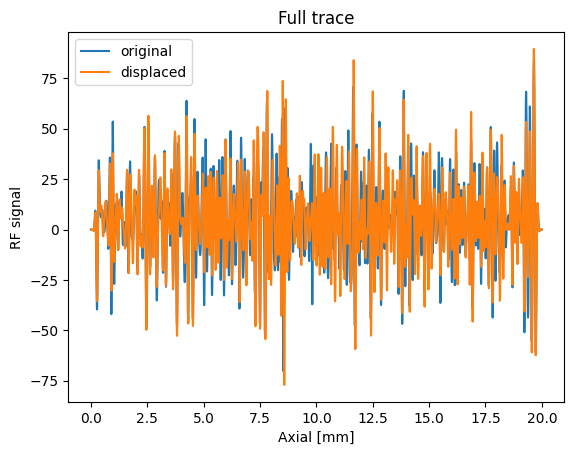

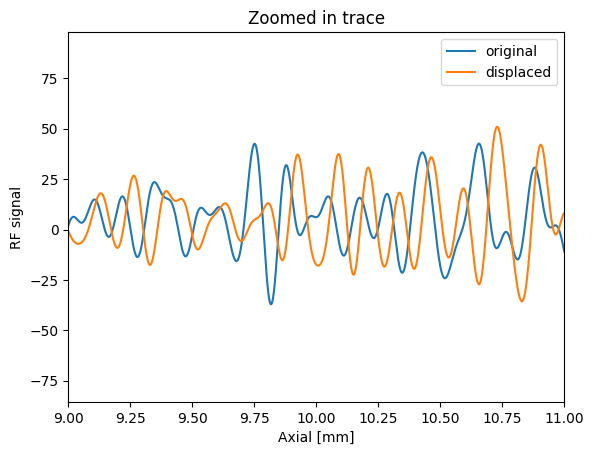

In [5]:
# define the displacement field
f_disp = lambda x, mag=50E-6: mag*np.exp(-(x-10E-3)**2/(2E-3**2))

ix0 = np.round((x0+f_disp(x0))/dx).astype(int)
a0 = rng.normal(5, 1, 10000)
a0[a0 <= 0.1] = 0.1
scat = np.zeros(len(x))
scat[ix0] += a0

trace1 = np.convolve(imp, scat, mode='same')

plt.figure()
plt.plot(1E3*x, trace0, label='original')
plt.plot(1E3*x, trace1, label='displaced')
plt.legend()
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Full trace")
plt.show()

plt.figure()
plt.plot(1E3*x, trace0, label='original')
plt.plot(1E3*x, trace1, label='displaced')
plt.legend()
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Zoomed in trace")
plt.xlim(9, 11)
plt.show()

## Displacement estimation using Kasai algorithm

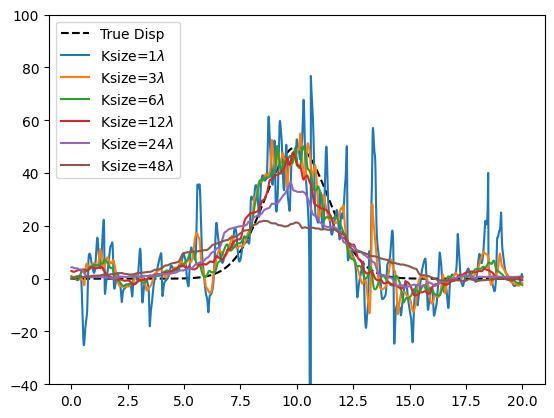

In [6]:
import dispest as de

# convert rfsignal to IQ to get phase information
IQ0 = sig.hilbert(trace0).reshape((-1,1))
IQ1 = sig.hilbert(trace1).reshape((-1,1))
IQ = np.concatenate((IQ0, IQ1), axis=1)
I = np.real(IQ)
Q = np.imag(IQ)

plt.figure()
plt.plot(1E3*x, 1E6*f_disp(x), color='k', linestyle='--', label='True Disp')

# calculate displacement with different kernel lengths
disps = []
for lam in [1, 3, 6, 12, 24, 48]:
    ksize = int(np.round(lam*fs/f))
    disp = de.calc_kasai(I, Q, taxis=1, fd=f, c=c, ksize=ksize, kaxis=0)
    plt.plot(1E3*x, disp, linestyle='-', label=  f"Ksize={lam}" + '$\\lambda $')

plt.legend()
plt.ylim(-40, 100)
plt.show()
